# Exploración y pre-procesamiento de la data

In [1]:
# Importo las librerías iniciales que voy a usar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Abro los archivos de training y testing que da la competencia
df_test = pd.read_csv('test.csv', index_col=0)
df_train = pd.read_csv('train.csv', index_col=0)

## Procesamiento de merge dataset

In [3]:
# junto los dos datasets para procesarlos
final_df = pd.concat([df_train,df_test],axis=0)

In [4]:
# Exploro el archivo
print(f'Tamaño del df:', final_df.shape)
print(f'Tipos de datos en las columnas:')
print(final_df.dtypes.value_counts())
#df_train.describe()

Tamaño del df: (2919, 80)
Tipos de datos en las columnas:
object     43
int64      25
float64    12
dtype: int64


Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SalePrice'],
      dtype='object')

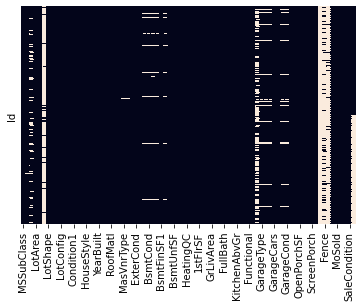

In [5]:
# Chequeo en que columnas hay valores nan
sns.heatmap(final_df.isnull(), yticklabels = False, cbar = False)
final_df.columns[final_df.isna().any()]

In [6]:
# Me fijo el porcentaje de valores nan que hay en cada una de esas columnas
columns_with_nan = final_df.isna().sum()/2919*100
columns_with_nan.sort_values(ascending=False).head(20)

PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
SalePrice       49.982871
FireplaceQu     48.646797
LotFrontage     16.649538
GarageCond       5.447071
GarageYrBlt      5.447071
GarageQual       5.447071
GarageFinish     5.447071
GarageType       5.378554
BsmtCond         2.809181
BsmtExposure     2.809181
BsmtQual         2.774923
BsmtFinType2     2.740665
BsmtFinType1     2.706406
MasVnrType       0.822199
MasVnrArea       0.787941
MSZoning         0.137033
dtype: float64

In [7]:
# Tiro aquellas columnas que tienen mas del 60% con nan values
final_df.drop(['PoolQC', 'MiscFeature','Alley', 'Fence',], axis = 1, inplace = True)
final_df.shape

(2919, 76)

In [8]:
# Chequeo si hay rows que tengan muchos nan values
final_df.isnull().sum(axis=1).sort_values(ascending=False).head()
# las rows que tienen nan values solo tienen 13 nan de 76 values que pueden tener
# no elimino ninguna

Id
1848    13
2121    13
2553    12
2190    12
2892    12
dtype: int64

In [9]:
# Llenos las 15 columnas que tienen valores nan...
# Voy a probar imputar los nan con KNN. Sklearn tiene un imputador con KNN.
# Para poder usarlo tengo que convertir todos las categóricas en dummies... 
# pero si hago esta codificación antes de reemplazar los missing values pierdo esos valores nan.

# me quedo con las variables categóricas
categorical_features = final_df.dtypes[final_df.dtypes == 'object'].index

# Sklearn tiene un label encoder que luego se concatena con one hot encoding
# pero necesita que los valores sean de un solo tipo, es decir que no maneja los np.nan como tal.
# si uno los pasa a 'str' los toma como un valor en sí y les asigna un valor numérico durante el labelencoder.
# con el siguiente código determino que valor le entregó al valor np.nan 
# y luego lo vuelvo a reemplazar para que siga siendo np.nan.

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

dic_list = []
for x in categorical_features:
    final_df[x+'_cat'] = labelencoder.fit_transform(final_df[x].astype(str))
    dic = dict(zip(final_df[x].unique(), final_df[x+'_cat'].unique())) # este es el diccionario que me permite ver como se codificó
    dic_list.append((x, dic)) # los guardo en una lista de tuples por si los necesito luego
    if np.nan in final_df[x].unique().tolist():
        final_df[x+'_cat'].replace(dic[np.nan], np.nan, inplace=True)


In [10]:
# chequeo que el encoding funcionó
print(final_df.FireplaceQu_cat.unique())
print(final_df.FireplaceQu.unique())
final_df[['FireplaceQu', 'FireplaceQu_cat']]

[nan  4.  2.  1.  0.  3.]
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']


,FireplaceQu,FireplaceQu_cat
Id,,
1,NaN,NaN
2,TA,4.0
3,TA,4.0
4,Gd,2.0
5,TA,4.0
...,...,...
2915,NaN,NaN
2916,NaN,NaN
2917,TA,4.0


Index([], dtype='object')

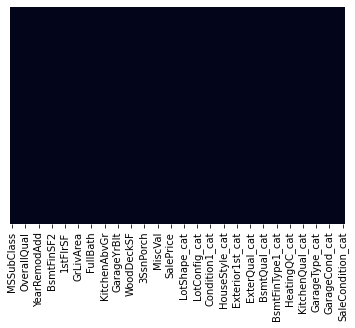

In [11]:
# para poder usar el KNNImputer necesito tirar las columnas categóricas viejas.
final_df.drop(categorical_features, axis = 1, inplace = True)

from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3, weights='distance') # uso 3 vecinos y se hace un promedio ponderado según la distancia euclidiana (a los más cercanos le da más peso)
final_df_imputed = imputer.fit_transform(final_df)
final_df_imputed = pd.DataFrame(final_df_imputed, columns=final_df.columns)

# Chequeo que efectivamente no haya más nan values
sns.heatmap(final_df_imputed.isnull(), yticklabels = False, cbar = False)
final_df_imputed.columns[final_df_imputed.isna().any()]

Como las columnas categóricas fueron codificadas con números, la predicción de las missing values se hace de forma numérica y me quedan floats muchas veces porque hace un promedio. Esto necesito que pase a ser un int así puedo mapearlo con el dictionario que tengo de antes.

In [12]:
new_categorical_features = []
for x in final_df_imputed.columns:
    if x[-4:] == '_cat':
        final_df_imputed[x] = final_df_imputed[x].astype(int)
        new_categorical_features.append(x)
final_df_imputed

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,KitchenQual_cat,Functional_cat,FireplaceQu_cat,GarageType_cat,GarageFinish_cat,GarageQual_cat,GarageCond_cat,PavedDrive_cat,SaleType_cat,SaleCondition_cat
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,2,6,4,1,1,4,4,2,8,4
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,3,6,4,1,1,4,4,2,8,4
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,2,6,4,1,1,4,4,2,8,4
3,70.0,60.0,9550.0,7.0,5.0,1915.0,1970.0,0.0,216.0,0.0,...,2,6,2,5,2,4,4,2,8,0
4,60.0,84.0,14260.0,8.0,5.0,2000.0,2000.0,350.0,655.0,0.0,...,2,6,4,1,1,4,4,2,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,160.0,21.0,1936.0,4.0,7.0,1970.0,1970.0,0.0,0.0,0.0,...,3,6,3,1,2,4,4,2,8,4
2915,160.0,21.0,1894.0,4.0,5.0,1970.0,1970.0,0.0,252.0,0.0,...,3,6,3,4,2,4,4,2,8,0
2916,20.0,160.0,20000.0,5.0,7.0,1960.0,1996.0,0.0,1224.0,0.0,...,3,6,4,5,2,4,4,2,8,0
2917,85.0,62.0,10441.0,5.0,5.0,1992.0,1992.0,0.0,337.0,0.0,...,3,6,3,2,1,3,3,2,8,4


In [13]:
# una vez llenos los missing values, hago el one hot encoding de las variables categóricas
# por comodidad lo hago con dummies
final_df_imputed = pd.get_dummies(final_df_imputed, columns=new_categorical_features)
final_df_imputed.shape

(2919, 276)

Ya está listo el pre-procesamiento de los datos. Ahora tengo que separar el train y el test set y comenzar con el desarrollo del modelo de machine learning

# Machine-Learning Model

Lo que se quiere predecir es un valor numérico. Para eso tengo variables numéricas y categóricas que describen cada uno de los casos (o entradas de la tabla). No todos los métodos de ML pueden usar una mezcla de tipos de variables. Uno de los más sencillos de abordar es el **RandomForest**. Otra ventaja del **RandomForest** es que no es necesario estandarizar/normalizar los datos numéricos (aunque hacerlo puede llegar a mejorar un poco la predicción).

In [19]:
# Separo los subsets
df_train = final_df_imputed.iloc[:1460,:]
df_test = final_df_imputed.iloc[1460:,:].drop(['SalePrice'], axis=1)

# Separo las variables descriptivas de lo que quiero predecir
# Me quedo con todo menos con SalePrice como X
X = df_train.drop(['SalePrice'],axis=1)
# Me quedo solo con SalePrice como y
y = df_train['SalePrice']

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Separo el dataset de training en subsets training y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # Mantener el random state me permite replicar resultados

# Comienzo con el Regressor (uso regressor y no classiffier porque la variable a predecir es numérica)
regressor = RandomForestRegressor(random_state=0)
# Fiteo el algoritmo a los subsets de entrenamiento
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [21]:
print(f'Regressor score on training subset:', regressor.score(X_train, y_train))
print(f'Regressor score on testing subset:', regressor.score(X_test, y_test))
from sklearn.metrics import mean_squared_error
y_pred = regressor.predict(X_test)
print(f'RootMeanSquaredError:', np.sqrt(mean_squared_error(y_test, y_pred)))

Regressor score on training subset: 0.9766280034360368
Regressor score on testing subset: 0.8477605195085054
RootMeanSquaredError: 31702.87656623985


Ya con estos scores veo que el modelo es un poco mejor que el de la versión 3

In [22]:
# Hiperparameter tunning con Cross-Validation 
# Randomized Search

from sklearn.model_selection import RandomizedSearchCV

# Número de árboles en el bosque
n_estimators = [int(x) for x in np.linspace(start = 1000, stop = 5000, num = 5)]
# Número de features a considerar en cada split
max_features = ['auto', 'sqrt']
# Número máximo de niveles por árbol
max_depth = [int(x) for x in np.linspace(50, 500, num = 10)]
max_depth.append(None)
# Número mínimo de muestras necesarias para abrir un nodo
min_samples_split = [2, 5, 10]
# Número mínimo de muestras por nodo
min_samples_leaf = [2, 5, 10]
# Método de selección de muestras para entrenar cada árbol
bootstrap = [True]
# Creación de la grilla random
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Se larga la búsqueda randomizada de hiperparámetros
rf_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid, 
                               n_iter = 50, cv = 3, verbose=2, random_state=0, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 19.0min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [50, 100, 150, 200, 250,
                                                      300, 350, 400, 450, 500,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [1000, 2000, 3000, 4000,
                                                         5000]},
                   random_state=0, verbose=2)

In [23]:
print(f'Regressor best params:', rf_random.best_params_)
print(f'Regressor score on training subset:', rf_random.best_estimator_.score(X_train, y_train))
print(f'Regressor score on testing subset:', rf_random.best_estimator_.score(X_test, y_test))
from sklearn.metrics import mean_squared_error
y_pred = rf_random.best_estimator_.predict(X_test)
print(f'RootMeanSquaredError:', np.sqrt(mean_squared_error(y_test, y_pred)))

Regressor best params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}
Regressor score on training subset: 0.9697623776533153
Regressor score on testing subset: 0.845083438864364
RootMeanSquaredError: 31980.404097365466


In [36]:
# Basandome en los parámetros de la RandomizedSearch seteo parámetros de búsqueda para la GridSearch
# De esta forma optimizo un poco más los hiperparámetros.
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 50, 100],
    'max_features': [100, 'auto'], # Es el 30 y el 60% del total - evito overfitting
    'min_samples_leaf': [2],
    'min_samples_split': [2],
    'n_estimators': [50, 100, 200, 500]
}


# Largamos la GridSearch
grid_search = GridSearchCV(estimator = regressor, param_grid = param_grid, 
                           cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.3min finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [10, 50, 100],
                         'max_features': [100, 'auto'], 'min_samples_leaf': [2],
                         'min_samples_split': [2],
                         'n_estimators': [50, 100, 200, 500]},
             verbose=2)

In [37]:
print(f'Regressor best params:', grid_search.best_params_)
print(f'Regressor score on training subset:', grid_search.best_estimator_.score(X_train, y_train))
print(f'Regressor score on testing subset:', grid_search.best_estimator_.score(X_test, y_test))
y_pred = grid_search.best_estimator_.predict(X_test)
print(f'RootMeanSquaredError:', np.sqrt(mean_squared_error(y_test, y_pred)))

Regressor best params: {'bootstrap': True, 'max_depth': 50, 'max_features': 100, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Regressor score on training subset: 0.9658261144399173
Regressor score on testing subset: 0.8503789644979087
RootMeanSquaredError: 31429.0570433044


/home/mariano/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Fold: 0
RootMeanSquaredError: 21583.194423976223
Score: 0.9103054920825143
Fold: 1
RootMeanSquaredError: 23353.03090309003
Score: 0.8864709893949622
Fold: 2
RootMeanSquaredError: 27285.877443292065
Score: 0.9117444962036595
Fold: 3
RootMeanSquaredError: 20614.1738906853
Score: 0.9224795190237295
Fold: 4
RootMeanSquaredError: 22793.673059912777
Score: 0.9006477093065081
Fold: 5
RootMeanSquaredError: 41276.25815424668
Score: 0.7334438899545064
Fold: 6
RootMeanSquaredError: 29020.86272781764
Score: 0.8687385463829354
Fold: 7
RootMeanSquaredError: 38912.31531642393
Score: 0.7769469170767281
Fold: 8
RootMeanSquaredError: 22231.987574317736
Score: 0.912898945816958
Fold: 9
RootMeanSquaredError: 35139.15881995021
Score: 0.8540500537950189
********************
Mean Metrics:
RootMeanSquaredError: 28221.053231371257
Score: 0.867772655903752


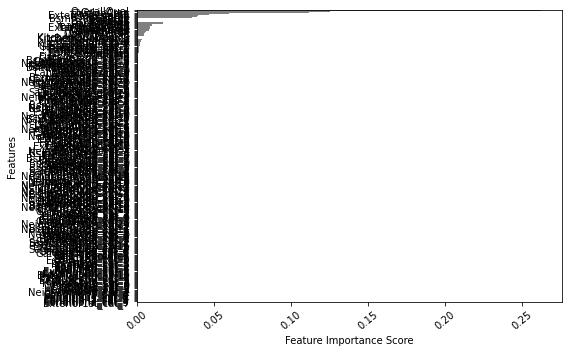

In [38]:
# Una vez que ya tengo los parámetros seteados puedo realizar una cross-validation 
# del modelo con todos los datos de el train set
params = grid_search.best_params_

regressor_final = RandomForestRegressor(bootstrap=params['bootstrap'], max_depth=params['max_depth'],
                                        max_features=params['max_features'], min_samples_leaf=params['min_samples_leaf'], 
                                        min_samples_split=params['min_samples_split'], n_estimators=params['n_estimators'], 
                                        random_state=0)

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

def CrossValidator(X, y):
    cv = StratifiedKFold(n_splits=10)
    rmse = []
    features_importances = []
    RMSE = []
    score = []
    for i, (train, test) in enumerate(cv.split(X, y)):
        regressor_final.fit(X.iloc[train], y.iloc[train])
        feature_imp = pd.Series(regressor_final.feature_importances_,index=X.columns).sort_values(ascending=False)
        features_importances.append(feature_imp)
        y_pred = regressor_final.predict(X.iloc[test])
        RMSE.append(np.sqrt(mean_squared_error(y.iloc[test], y_pred)))
        score.append(regressor_final.score(X.iloc[test], y.iloc[test]))
        print(f'Fold:', i)
        print(f'RootMeanSquaredError:', np.sqrt(mean_squared_error(y.iloc[test], y_pred)))
        print(f'Score:', regressor_final.score(X.iloc[test], y.iloc[test]))

    print('*'*20)
    print(f'Mean Metrics:')
    print(f'RootMeanSquaredError:', np.mean(RMSE))
    print(f'Score:', np.mean(score))

    plt.figure(figsize=(8,5))
    feat_impor_mean = pd.Series(sum(features_importances)/len(features_importances)).sort_values(ascending=False)
    sns.barplot(x=feat_impor_mean, y=feature_imp.index, color='grey')
    plt.xticks(rotation=40)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

CrossValidator(X, y)

In [39]:
# Acá me aseguro que el test set tenga las mismas features que el train

features_finals = list(X.columns)

df_test = df_test[features_finals]

print(f'Train Shape:', X.shape)
print(f'Train Columns:', X.columns)
print(f'Test Shape:', df_test.shape)
print(f'Test Columns:', df_test.columns)
df_test.head()

Train Shape: (1460, 275)
Train Columns: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_cat_5', 'SaleType_cat_6', 'SaleType_cat_7', 'SaleType_cat_8',
       'SaleCondition_cat_0', 'SaleCondition_cat_1', 'SaleCondition_cat_2',
       'SaleCondition_cat_3', 'SaleCondition_cat_4', 'SaleCondition_cat_5'],
      dtype='object', length=275)
Test Shape: (1459, 275)
Test Columns: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_cat_5', 'SaleType_cat_6', 'SaleType_cat_7', 'SaleType_cat_8',
       'SaleCondition_cat_0', 'SaleCondition_cat_1', 'SaleCondition_cat_2',
       'SaleCondition_cat_3', 'SaleCondition_cat_4', 'SaleCondition_cat_5'],
      dtype='object', length=275)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_cat_5,SaleType_cat_6,SaleType_cat_7,SaleType_cat_8,SaleCondition_cat_0,SaleCondition_cat_1,SaleCondition_cat_2,SaleCondition_cat_3,SaleCondition_cat_4,SaleCondition_cat_5
1460,20.0,80.0,11622.0,5.0,6.0,1961.0,1961.0,0.0,468.0,144.0,...,0,0,0,1,0,0,0,0,1,0
1461,20.0,81.0,14267.0,6.0,6.0,1958.0,1958.0,108.0,923.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1462,60.0,74.0,13830.0,5.0,5.0,1997.0,1998.0,0.0,791.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1463,60.0,78.0,9978.0,6.0,6.0,1998.0,1998.0,20.0,602.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1464,120.0,43.0,5005.0,8.0,5.0,1992.0,1992.0,0.0,263.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [40]:
# Entro el regresor final con todo el data set
regressor_final.fit(X, y)
# y predigo lo que quiero saber
SalePrice = regressor_final.predict(df_test)

# Le doy el formato que me pide Kaggle
Id = list(df_test.index)

df = pd.DataFrame()
df['Id'] = Id
df['Id'] = df['Id']+1
df['SalePrice'] = SalePrice
df.set_index('Id', drop=True, inplace=True)
df.to_csv('NIS_MM_submission_4.csv')

In [41]:
df = pd.read_csv('NIS_MM_submission_4.csv')
df

,Id,SalePrice
0,1461,125950.182270
1,1462,153642.536364
2,1463,179595.749119
3,1464,188017.978968
4,1465,197444.256905
...,...,...
1454,2915,87269.558571
1455,2916,86686.237738
1456,2917,155033.246000
1457,2918,116128.583333
